# Image Compression by K-Means Clustering
    Author: Furkan Cantürk
    Date: 13.12.2020

In [1]:
from PIL import Image
from io import BytesIO
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
try:
    import plotly.express as px
except:
    ! pip install plotly
    import plotly.express as px #for interactive 3-D plotting
random.seed(42)

# Image Operations

In [2]:
#Resize image to given dimensions, remove transparency value, and convert 3D image array to 2D
def convert(image, dimensions):
    resized_img = image.resize(dimensions[:2])
    img_arr = np.asarray(resized_img)
    return resized_img, img_arr[:,:,:3].reshape(dimensions[0]*dimensions[1], -1).astype(int)

# Get image size as KB
def get_size(img, format='png'):
    img_file = BytesIO()
    image = Image.fromarray(np.uint8(img))
    image.save(img_file, format)
    return img_file.tell()/1024

#Save image and return its Image object form
def save(img_arr, filename):
    img  = Image.fromarray(img_arr.astype("uint8"))
    img.save(image_name+f"/{filename}.jpg")
    return img

# K-Means Clustering and Replacing Pixels with Centroid Colors

In [3]:
#Implement k-means clustering to compress image using k colors

def compress_with_kmeans(img_array, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(img_array)
    
    #Get centroid pixel values
    centers = kmeans.cluster_centers_
    
    #Convert real number RGB values to integers
    centers = np.clip(centers.astype(int), 0, 255)
    
    #Replace each pixel with centroids by their labels
    cluster_labels = kmeans.labels_
    compressed_img_array = centers[cluster_labels]
    
    return compressed_img_array, centers, cluster_labels, kmeans

In [4]:
# Generate a list of clusters

def list_clustered_pixels(image_array, cluster_labels, cluster_ids):
    return [image_array[cluster_labels == c_id] for c_id in cluster_ids]

# Formulas

In [6]:
def euclidian(p1, p2):
    return np.sum((p1 - p2)**2, axis=1)**0.5

def silhouette(a, b):
    return (b - a)/max(a,b)

def calculate_total_WCSS(centers, clusters, cluster_ids):
    WCSS = []
    for c_id in cluster_ids:
        WCSS.append( sum( euclidian(centers[c_id], clusters[c_id])**2) ) 
    TWCSS = sum(WCSS)
    return TWCSS

def calculate_total_SS(img_arr):
    return sum(np.var(img_arr, axis=0)* len(img_arr)) 

# Loading Image

In [7]:
image_name = "umbrella" #baboon, landscape, lenna, peppers, umbrella
file_type = ".png"
raw_img = Image.open(image_name+file_type)
raw_img_arr = np.asarray(raw_img)
n_unique_colors = len(np.unique(raw_img_arr[:,:,:3].reshape(raw_img_arr.shape[0]*raw_img_arr.shape[1], -1), axis=0))
raw_img_size = get_size(raw_img)

print("Dimensions of original image:", raw_img_arr.shape)
print("Number of unique colors:", n_unique_colors)
print("Original Image size (Kb):", raw_img_size)

Dimensions of original image: (512, 512, 4)
Number of unique colors: 135560
Original Image size (Kb): 467.7763671875


# Preprocessing Image

Dimensions of converted image: (256, 256, 3)
Number of unique colors: 45334
Converted Image size (KB): 133.8857421875


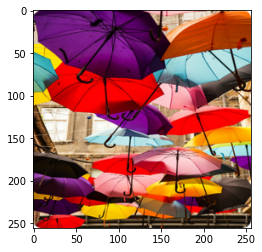

In [8]:
dimensions = (256,256,3)

img, img_arr = convert(raw_img, dimensions)
n_colors = len(np.unique(img_arr, axis=0))
img_size = get_size(img_arr)

plt.imshow(img)
print("Dimensions of converted image:", dimensions)
print("Number of unique colors:", n_colors)
print("Converted Image size (KB):", img_size)

In [9]:
#3-D Plotting sampled pixel values of original image

data = pd.DataFrame(img_arr, columns=["R", "G", "B"]).sample(5000)
data_str = data.astype(str)
data_str["RGB"] = "rgb(" + data_str.R + "," + data_str.G + "," + data_str.B + ")"
fig = px.scatter_3d(data, x="R", y="G", z="B")
fig.update_traces(marker=dict(size=2, color=data_str.RGB))
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

# Image Compressions with 2^k Colors

In [10]:
max_k = 8
compressed_images = []
size_lst = []
TWCSS_lst = []
TBCSS_lst = []
explained_var_lst = []
k_range = np.arange(1, max_k+1)
n_color_list = 2 ** k_range

for k in k_range:
    n_color = 2**k
    cluster_ids = list(range(n_color))
    
    #Apply k-means and get centroids, 2-D compressed image data
    compressed_img_2d, centers, cluster_labels, kmeans = compress_with_kmeans(img_arr, n_color)
    
    #Reshape the image to original dimensions
    compressed_img_3d = compressed_img_2d.reshape(dimensions[0], dimensions[1], 3)
    
    #Save the compressed image
    compressed_img_name = image_name+str(n_color)
    compressed_img = save(compressed_img_3d, compressed_img_name+'.jpg')
    
    #Calculation number of bits to represent the compressed image
    size = get_size(compressed_img_2d)
    
    #List clustered pixels
    clusters = list_clustered_pixels(img_arr, cluster_labels, cluster_ids)
    
    #Calculation of Explained Variance by the compressed image
    TWCSS = calculate_total_WCSS(centers, clusters, cluster_ids)
    TSS = calculate_total_SS(img_arr)
    TBCSS = TSS - TWCSS
    explained_var = TBCSS / TSS
    
    #Save the statictics
    compressed_images.append(compressed_img)
    size_lst.append(size)
    TWCSS_lst.append(TWCSS)
    TBCSS_lst.append(TBCSS)
    explained_var_lst.append(explained_var)

In [11]:
name_lst = [image_name] * max_k
df = pd.DataFrame(list(zip(name_lst, n_color_list, size_lst, TWCSS_lst, TBCSS_lst, explained_var_lst)), 
                  columns=["Image", "#colors", "Size", "TWCSS", "TBCSS", "Explained Var."]).set_index(["Image", "#colors"])
df

Size        TWCSS         TBCSS  Explained Var.
Image    #colors                                                      
umbrella 2         4.968750  612568693.0  5.877032e+08        0.489642
         4        10.416016  313789765.0  8.864821e+08        0.738568
         8        13.887695  152124905.0  1.048147e+09        0.873258
         16       21.932617   89805545.0  1.110466e+09        0.925179
         32       30.941406   64313463.0  1.135958e+09        0.946418
         64       43.316406   51759159.0  1.148513e+09        0.956877
         128      58.022461   45331363.0  1.154941e+09        0.962232
         256      74.315430   42246932.0  1.158025e+09        0.964802

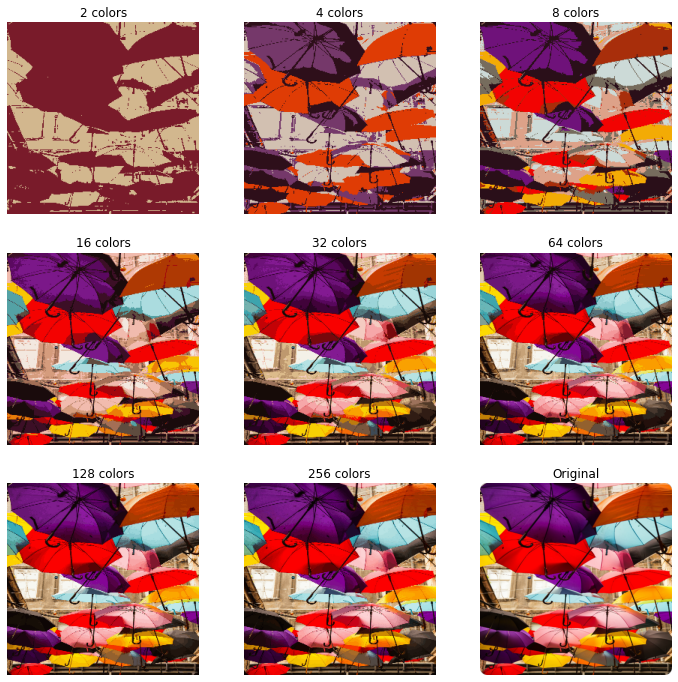

In [12]:
#Plotting compressed images and the original image

fig, axs = plt.subplots(3,3, figsize=(12,12))
iter_images = iter(compressed_images + [raw_img])
iter_n_color = iter(n_color_list)
for i in range(3):
    for j in range(3):
        img = next(iter_images)
        axs[i][j].imshow(img)
        axs[i][j].axis('off')
        if i+j == len(n_color_list)-4:
            axs[i][j].set_title("Original")
        else:
            axs[i][j].set_title(str(next(iter_n_color)) + " colors")

# Choosing Optimal Number of Colors for Compression

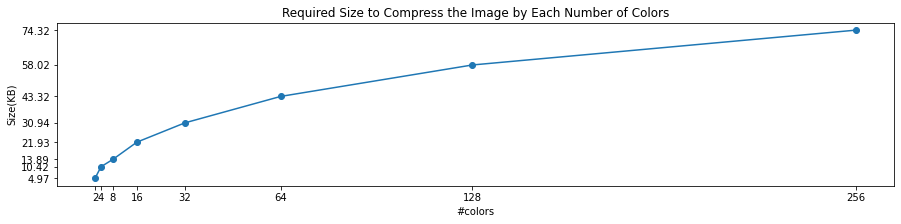

In [13]:
plt.figure(figsize=(15,3))
plt.plot(n_color_list, size_lst, marker="o")
plt.title("Required Size to Compress the Image by Each Number of Colors")
plt.yticks(size_lst)
plt.xticks(n_color_list)
plt.xlabel("#colors")
plt.ylabel("Size(KB)")
plt.show()

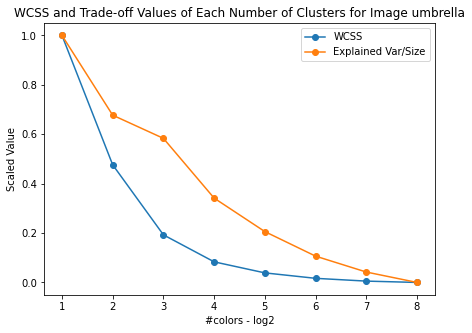

In [14]:
var_size = np.array(explained_var_lst) / np.array(size_lst)
scaled_var_size = MinMaxScaler().fit_transform(var_size.reshape(-1,1))
scaled_SSE = MinMaxScaler().fit_transform(np.array(TWCSS_lst).reshape(-1,1))

plt.figure(figsize=(7,5))
plt.plot(k_range, scaled_SSE, marker='o', label="WCSS")
plt.plot(k_range, scaled_var_size, marker='o', label="Explained Var/Size")
plt.title("WCSS and Trade-off Values of Each Number of Clusters for Image "+ image_name)
plt.xticks(k_range)
plt.xlabel("#colors - log2")
plt.ylabel("Scaled Value")
plt.legend(loc="best")
plt.show()

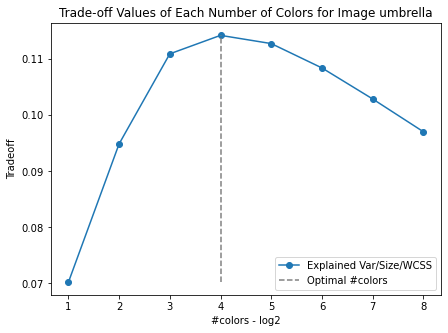

In [15]:
# Standard scaling each measure
scaled_sizes = StandardScaler().fit_transform(np.array(size_lst).reshape(-1,1)).flatten()
scaled_explained_var = StandardScaler().fit_transform(np.array(explained_var_lst).reshape(-1,1)).flatten()
scaled_SSE = StandardScaler().fit_transform(np.array(TWCSS_lst).reshape(-1,1)).flatten()

#Shift each measure and compute tradeoff value
tradeoff = (scaled_explained_var+10) / (scaled_sizes+10) / (scaled_SSE+10)
opt_k = np.argmax(tradeoff)+1

plt.figure(figsize=(7,5))
plt.plot(k_range, tradeoff, marker='o', label="Explained Var/Size/WCSS")
plt.plot([opt_k, opt_k], [min(tradeoff),max(tradeoff)], '--', color='gray', label="Optimal #colors")
plt.title("Trade-off Values of Each Number of Colors for Image "+ image_name)
plt.xticks(k_range)
plt.xlabel("#colors - log2")
plt.ylabel("Tradeoff")
plt.legend(loc="best")
plt.show()

In [16]:
optimal_n_colors = 2 ** opt_k
print("Optimal number of colors:", optimal_n_colors)

Optimal number of colors: 16


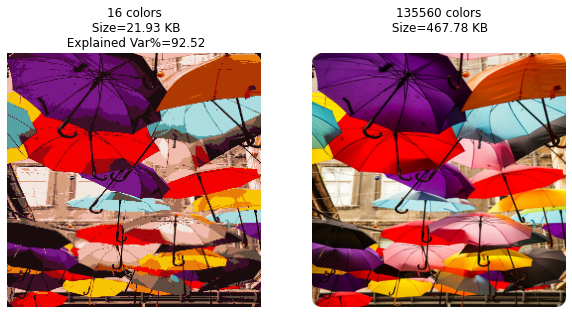

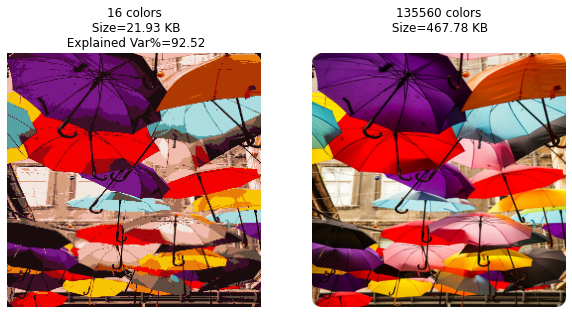

In [20]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(compressed_images[opt_k-1])
axs[0].axis("off")
axs[0].set_title(f"{optimal_n_colors} colors\n Size={round(size_lst[opt_k-1],2)} KB\n Explained Var%={round(explained_var_lst[opt_k-1]*100,2)}")
axs[1].imshow(raw_img)
axs[1].axis("off")
axs[1].set_title(f"{n_unique_colors} colors\n Size={round(raw_img_size,2)} KB\n")
fig

# Silhouette Coefficients

In [18]:
#sample_size = 1000
#img_idx = np.arange(img_arr.shape[0])
#sample_img_idx = np.random.choice(img_idx, replace=False, size=sample_size)
#sample_img = img_arr[img_idx]

#a = [np.mean(euclidian(clusters[cluster_labels[i]], img_arr[i]) ) for i in sample_img_idx]
#b = [np.min( [ np.mean(euclidian(clusters[c_id], img_arr[i])) for c_id in cluster_ids if c_id != cluster_labels[i] ] ) for i in sample_img_idx]
#silhouette_coefs = [silhouette(a[i], b[i]) for i in range(sample_size)]

#print(f"Mean of {sample_size} Silhouette Coefficients = {np.mean(silhouette_coefs)}")